## Import all the necessary libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

## Importing the dataset


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage", shuffle=True, image_size=(256, 256),
                                                   batch_size=32)

Found 2152 files belonging to 3 classes.


In [5]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) # --> There are 68 dataset as the batch size is 32, that means the 2152 files are split into 68 dataset each having 32 files.

68

## Visualizing the data

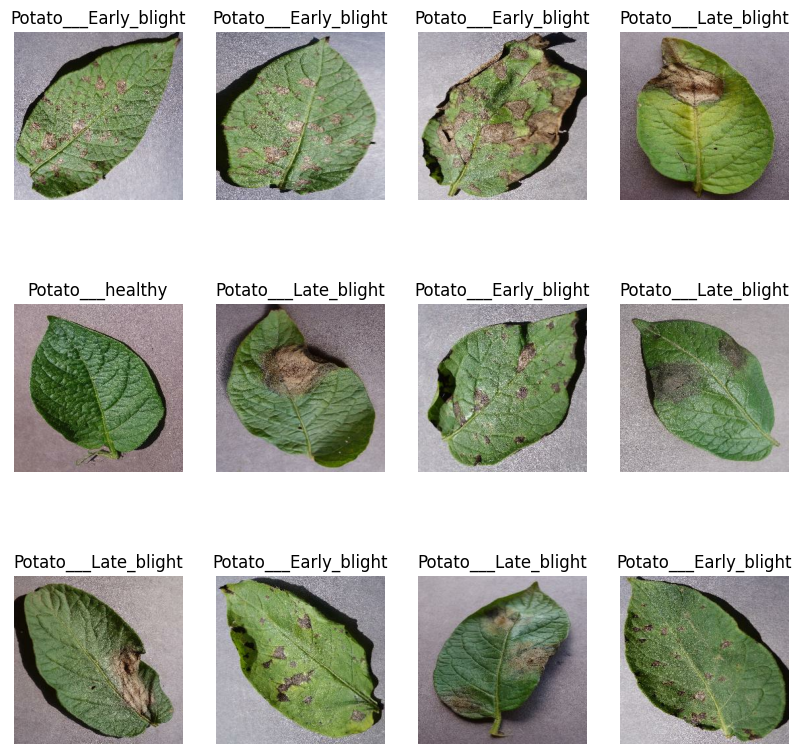

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

## Splitting the dataset into training, validation and test dataset 


In [9]:
def split_dataset(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split* ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train, val, test = split_dataset(dataset)

In [11]:
len(train)+len(val)+len(test)

68

In [12]:
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Building the Model

In [12]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
num_class = len(class_name)

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_class, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=val,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 57s 1s/step - loss: 0.9148 - accuracy: 0.4763 - val_loss: 0.8154 - val_accuracy: 0.5156
Epoch 2/50
54/54 [==============================] - 53s 973ms/step - loss: 0.6993 - accuracy: 0.6701 - val_loss: 0.6619 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 53s 979ms/step - loss: 0.4973 - accuracy: 0.7737 - val_loss: 0.4076 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 53s 984ms/step - loss: 0.4170 - accuracy: 0.8328 - val_loss: 0.2809 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 53s 984ms/step - loss: 0.2792 - accuracy: 0.8872 - val_loss: 0.2007 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 53s 982ms/step - loss: 0.1934 - accuracy: 0.9300 - val_loss: 0.1355 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 53s 977ms/step - loss: 0.1353 - accuracy: 0.9473 - val_loss: 0.1143 - val_accuracy: 0.9583
Ep

In [21]:
scores = model.evaluate(test)

8/8 [==============================] - 2s 176ms/step - loss: 0.0587 - accuracy: 0.9844


In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

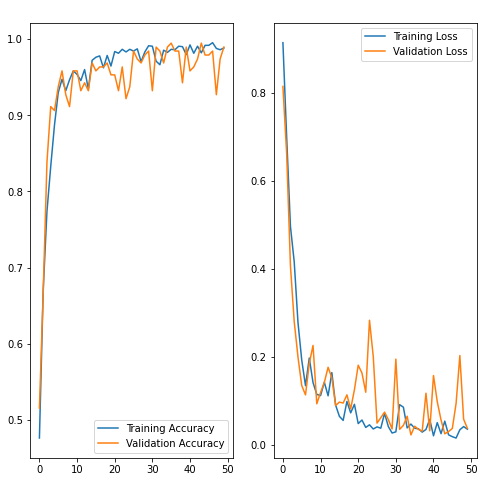

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', color = "white")

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', color = "white")
plt.show()

## Prediction with Test Images

In [12]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


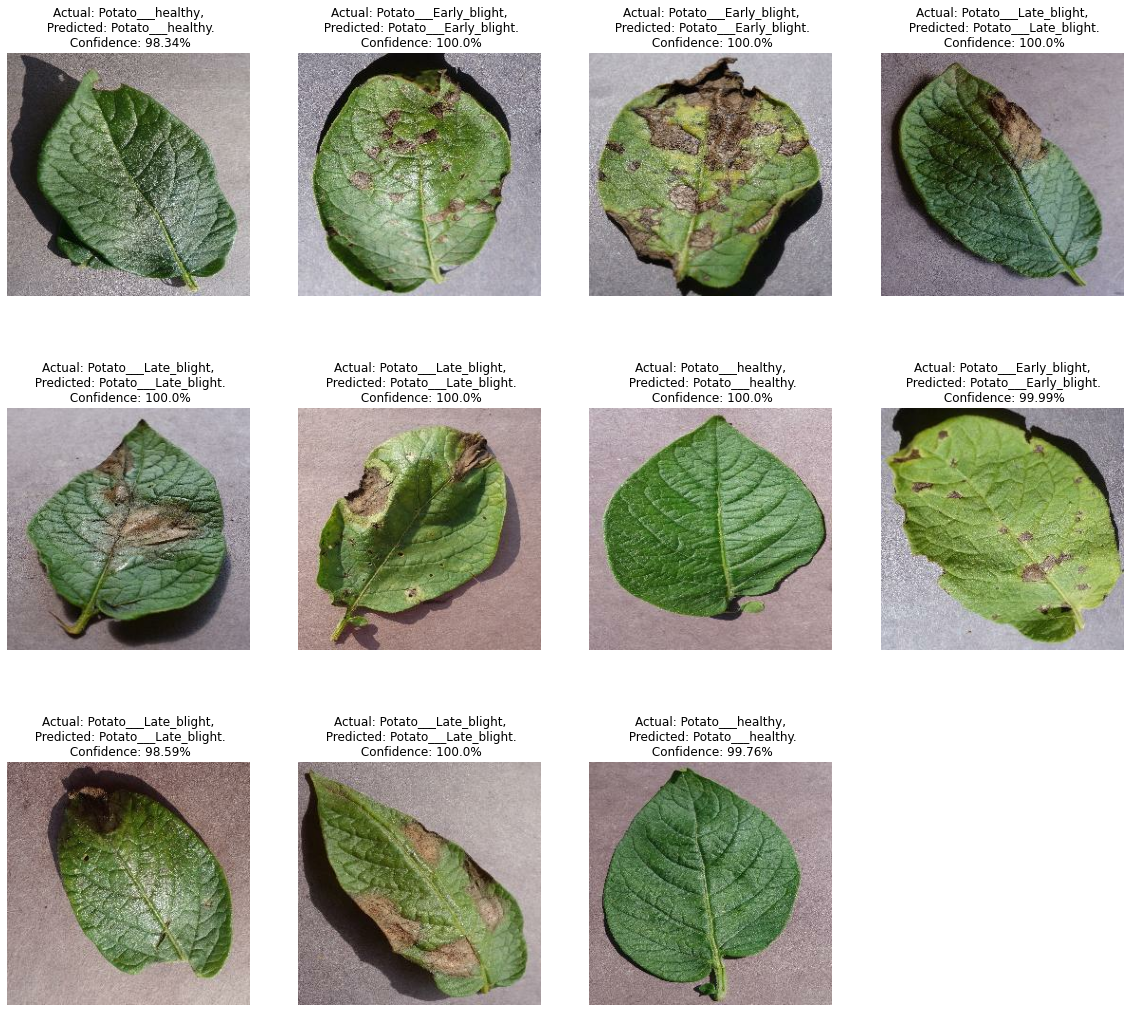

In [14]:
plt.figure(figsize=(20, 25))
for images, labels in test.take(1):
    for i in range(11):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
model.save("potatoes.h5")

C:\Users\excal\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 198ms/step
0
predicted class:  Potato___Early_blight
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


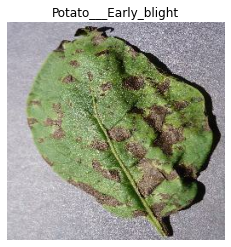

In [17]:
for image_batch, label_batch in test.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_name[label_batch[0]])
    plt.axis("off")
    batch_prediction = model.predict(image_batch)
    print(np.argmax(batch_prediction[0]))
    print("predicted class: ",class_name[np.argmax(batch_prediction[0])])
    print(class_name)

In [8]:
from tensorflow.keras.models import load_model
model = load_model('potatoes.h5')

In [13]:
img = tf.keras.preprocessing.image.load_img('test.jpg', target_size=(256,256))
img_array = tf.keras.preprocessing.image.img_to_array(img)

prediction, confidence = predict(model, img_array)
print(prediction, confidence)

1/1 [==============================] - 0s 166ms/step
Potato___Late_blight 99.89
